In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
import tqdm

In [2]:
%matplotlib notebook

## Parameters

In [3]:
_range = np.arange(-3, 3, 0.001)
_stepsize = 0.001            # Discretization of the strategies
alpha = 2                   # Parameter of J
beta = 1                    # Reweighting paramenter
gamma = 1.0                 # Additional update paremeter
delta_t = 0.05              # Stepsize at each iteration
total_steps = 30000
# max_iterations = 40000
N = 4

## Setup
We want to minimize the following function using EGT

In [4]:
def f(x):
    return x ** 2 + 0.5 * np.sin(10*x)

Now create our initial population

In [5]:
# All available strategies:
U = np.arange(-1+_stepsize, 1-_stepsize, _stepsize)

# Initial mixed strategy - continuous:
sigma = np.exp(-1/(1-(U**2)))
sigma = sigma / np.sum(sigma)

# Now with more than two points
population = []
#for i in range(N):
#    population.append([np.random.uniform(-2, 2), sigma])
population.append([0, sigma])
population.append([1, sigma])
population.append([-1, sigma])


# This element will keep track of everything that happens
history = []
history.append([])
history[-1] = population

Now we describe the game

In [6]:
def positive(x):
    return (np.abs(x) + x)/2

# Original J as proposed by Prof. Fornasier
def J(x, u, x2):
    return np.exp(
        -((u - positive(np.tanh(3*(f(x) - f(x2)))) * (x2 - x))**2) /
        ((x-x2) ** alpha + (f(x) - f(x2)) ** alpha))

# Here I can play around:
def J(x, u, x2):
    return np.exp(
        -((u - positive(np.tanh(3*(f(x) - f(x2)))) * (x2 - x))**2) /
        ((x-x2) ** alpha + (f(x) - f(x2)) ** alpha))

## Simulation 

In [7]:
print('Start')
sim_bar = tqdm.tqdm(range(total_steps))
sim_bar.set_description('Simulation')
for i in sim_bar:
    current_pop = history[-1]
    history.append([])

    # if i % 1000 == 0:
    #     print([y[0] for y in current_pop])

    deltas = []
    for j, (x1, sigma1) in enumerate(current_pop):
        # rescale_factor = np.sum([np.exp(- beta * f(x2)) for k, (x2, _) in enumerate(current_pop) if k != j])
        # deltas.append(1/rescale_factor * np.sum(
        #     [(J(x1, U, x2)-np.sum(J(x1, U, x2) * sigma1)) * np.exp(-beta*f(x2))
        #      for k, (x2, _) in enumerate(current_pop) if k != j], axis=0))
        deltas.append(1/len(current_pop) * np.sum(
            [(J(x1, U, x2)-np.sum(J(x1, U, x2) * sigma1))
             for k, (x2, _) in enumerate(current_pop) if k != j], axis=0))

    for j in range(len(current_pop)):
        new_strat = history[-2][j][1] * (1 + gamma * delta_t * deltas[j])
        new_strat /= np.sum(new_strat)
        new_loc = history[-2][j][0] + delta_t*np.random.choice(U, p=new_strat)
        history[-1].append([new_loc, new_strat])

    # Break condition for early stopping
    _locs = [y[0] for y in history[-1]]
    if max(_locs) - min(_locs) < 0.01:
        print('Early stopping thanks to our rule!')
        break

Simulation:   0%|          | 112/30000 [00:00<00:26, 1112.20it/s]

Start


Simulation:   8%|▊         | 2436/30000 [00:02<00:23, 1149.48it/s]

Early stopping thanks to our rule!


## Visualization

<IPython.core.display.Javascript object>


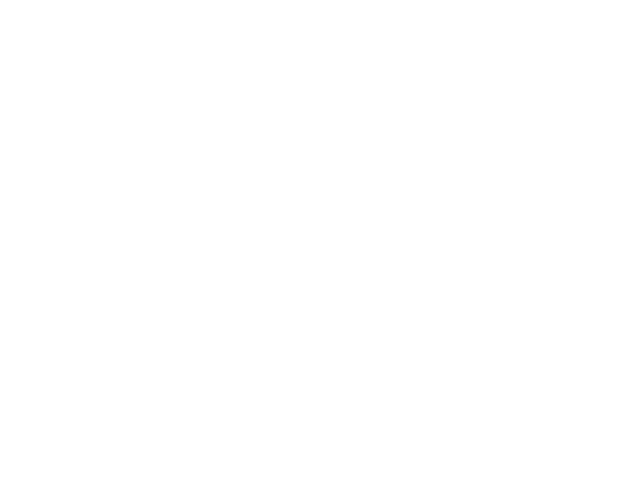

In [8]:
%matplotlib notebook

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
_xmin, _xmax = _range.min(), _range.max()
_ymin, _ymax = f(_range).min(), f(_range).max()
ax = plt.axes(
    xlim=(_xmin, _xmax),
    ylim=(_ymin, _ymax))
dots, = ax.plot([], [], 'ro')
base_function, = ax.plot([], [], lw=2)
base_function.set_data(_range, f(_range))
line2, = ax.plot([], [])


# initialization function: plot the background of each frame
def init():
    dots.set_data([], [])
    line2.set_data([], [])
    return dots, line2


# animation function.  This is called sequentially
def animate(i):
    current_pop = history[i]
    point_locations_x = np.array([y[0] for y in current_pop])
    point_locations_y = f(point_locations_x)
    dots.set_data(point_locations_x, point_locations_y)
    y1 = current_pop[0]
    # print(y1)
    line2.set_data(y1[0] + U, y1[1]/np.max(y1[1]))
    return dots, line2


# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(history), interval=20, blit=True,
                               repeat=False)

## Strategy Visualisation

<IPython.core.display.Javascript object>


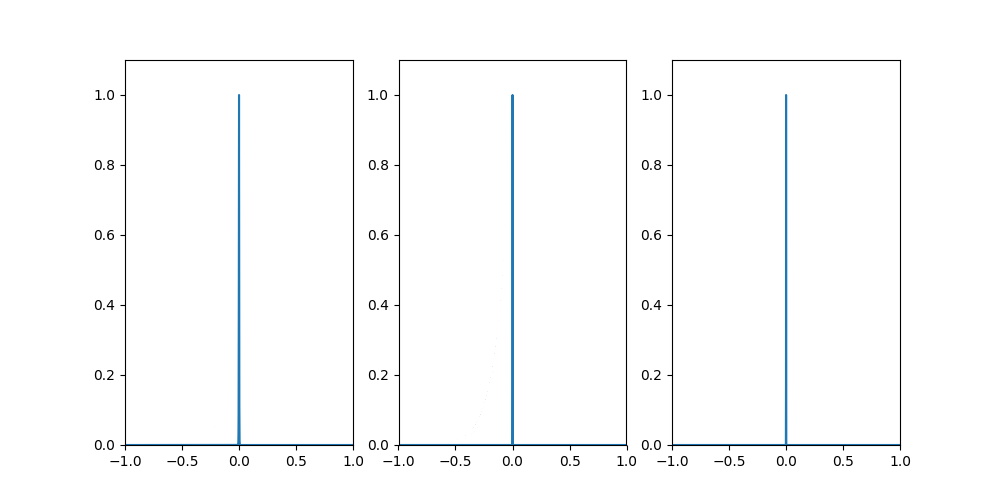

In [27]:
%matplotlib notebook

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure(figsize=(10, 5))
axarr = fig.subplots(1, len(history[0]))
for ax in axarr:
    ax.set_ylim([0, 1.1])
    ax.set_xlim([U.min(), U.max()])

linearr = []
for ax in axarr:
    line, = ax.plot([], [])
    linearr.append(line)

# initialization function: plot the background of each frame
def init():
    for line in linearr:
        line.set_data([], [])
    return linearr

# animation function.  This is called sequentially
def animate(i):
    current_pop = history[i]
    
    for j, y in enumerate(current_pop):
        linearr[j].set_data(U, y[1]/np.max(y[1]))
    return linearr


# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(history), interval=20, blit=True,
                               repeat=False)